# Lab: Images as Matrices — A Gentle Intro for COMP3057

**What you'll learn**
- Load **built‑in images** 🧩 (no downloads, no Lena)
- Display images 👁️ with **Matplotlib** and understand tensor shapes
- See raw pixel matrices 🔢, split/merge RGB channels
- Perform simple operations 🛠️ (crop, concat, grid, brightness, tiny convolution)

**Libraries**: `torch`, `torchvision`, `skimage`, `matplotlib`


## 0. Setup-Run this part on your own⚙️  

In [1]:
import torch
import torchvision
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

print("Setup complete! 🎉")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Setup complete! 🎉
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126


## 1. Load Built‑in Images - Run this part on your own 🖼️
We'll use **`skimage.data`** which ships with classic example images.

In [2]:
# RGB example (uint8, shape [H, W, 3])
np_img_rgb = data.astronaut()

# Grayscale example (uint8, shape [H, W])
np_img_gray = data.camera()

print('astronaut (RGB) numpy shape:', np_img_rgb.shape, np_img_rgb.dtype)
print('camera (GRAY) numpy shape  :', np_img_gray.shape,  np_img_gray.dtype)

astronaut (RGB) numpy shape: (512, 512, 3) uint8
camera (GRAY) numpy shape  : (512, 512) uint8


## 2. Display with Matplotlib 👀
Use **`plt.imshow`**. For Torch tensors ([C, H, W]), remember to **permute** to [H, W, C].

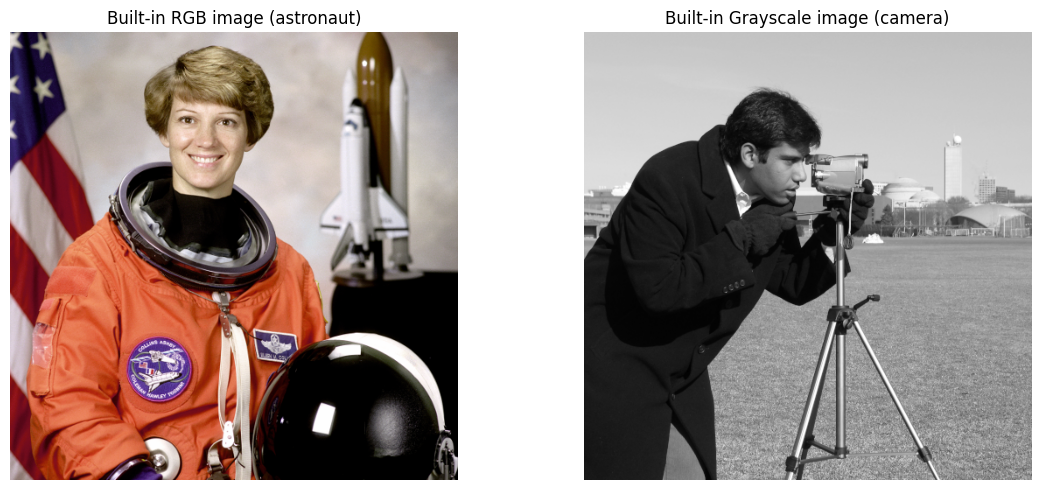

In [3]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(np_img_rgb)
plt.title('Built-in RGB image (astronaut)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np_img_gray, cmap='gray')
plt.title('Built-in Grayscale image (camera)')
plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Convert to Torch Tensors 🔄
- RGB numpy `[H, W, 3]` → Torch `[3, H, W]`
- GRAY numpy `[H, W]` → Torch `[1, H, W]`

In [22]:
img_rgb = torch.from_numpy(np_img_rgb).permute(2, 0, 1)  # [3, H, W]
img_gray = torch.from_numpy(np_img_gray).unsqueeze(0)     # [1, H, W]
print('RGB torch shape [C,H,W]:', img_rgb.shape, img_rgb.dtype)
print('GRAY torch shape [C,H,W]:', img_gray.shape, img_gray.dtype)

RGB torch shape [C,H,W]: torch.Size([3, 512, 512]) torch.uint8
GRAY torch shape [C,H,W]: torch.Size([1, 512, 512]) torch.uint8


In [23]:
# Safety check: ensure dtype is uint8 for display (0-255)
if img_rgb.dtype != torch.uint8:
    img_rgb = torch.clamp(img_rgb, 0, 255).to(torch.uint8)
if img_gray.dtype != torch.uint8:
    img_gray = torch.clamp(img_gray, 0, 255).to(torch.uint8)

print("Data types converted to uint8 for proper display")

Data types converted to uint8 for proper display


## 4. 🧠 Exercise — *Image = Matrix* 📊


🎯**PURPOSE:**

This exercise demonstrates that images are fundamentally just matrices of numbers.

By creating and visualizing a random matrix, students will understand:

1. **CORE CONCEPT**: Every image is a 2D array of pixel values (0-255)
2. **VISUALIZATION**: How numbers translate to visual patterns
3. **MATRIX STRUCTURE**: Rows = image height, Columns = image width

**Goal**: See the direct connection between numerical data and visual representation.







Small 8x8 matrix (uint8 pixel values):
 tensor([[102, 179,  92,  14, 106,  71, 188,  20],
        [102, 121, 210, 214,  74, 202,  87, 116],
        [ 99, 103, 151, 130, 149,  52,   1,  87],
        [235, 157,  37, 129, 191, 187,  20, 160],
        [203,  57,  21, 252, 235,  88,  48, 218],
        [ 58, 254, 169, 255, 219, 187, 207,  14],
        [189, 189, 174, 189,  50, 107,  54, 243],
        [ 63, 248, 130, 228,  50, 134,  20,  72]], dtype=torch.uint8)


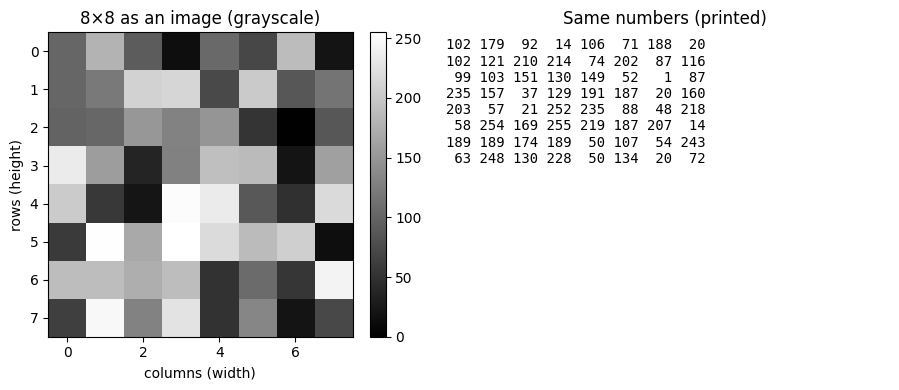

Image tensor shape = (128, 192)   → (rows=height, cols=width)
Pixel dtype = torch.uint8, range ≈ [0, 255]


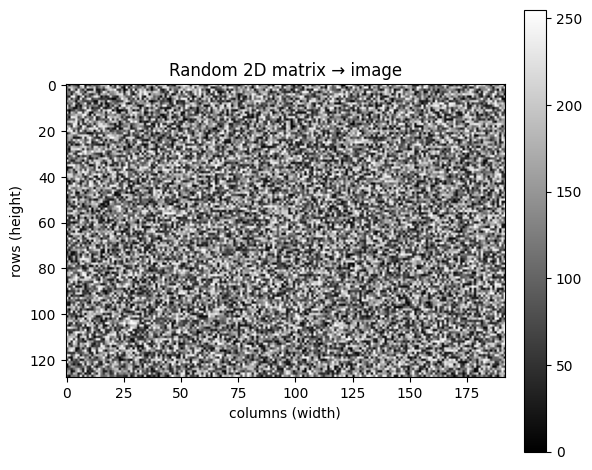

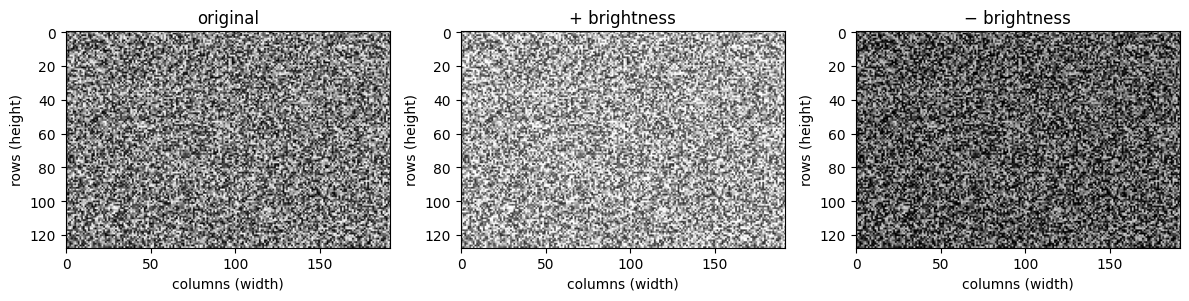

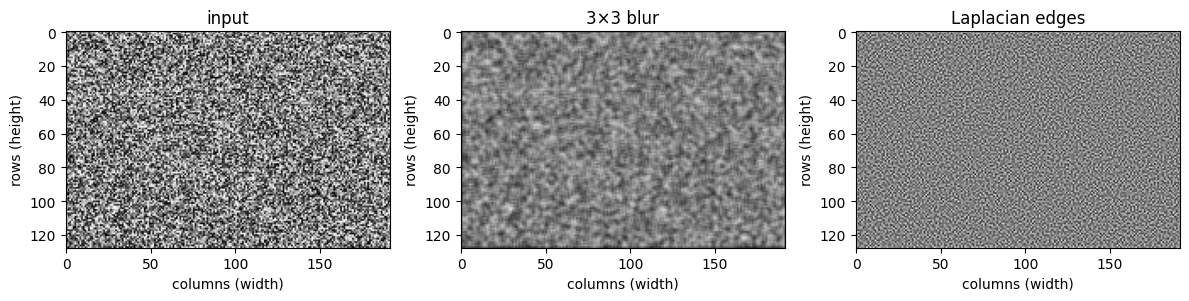

RGB (C,H,W) = (3, 128, 192)  → convert to (H,W,C) = (128, 192, 3)


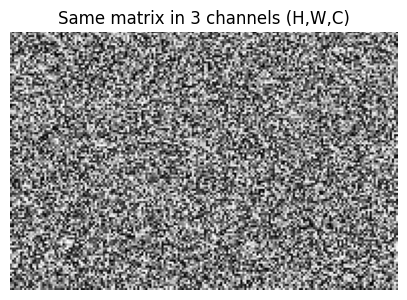

In [18]:
# %% [markdown]
# # COMP3057 — Images as Matrices (Exercise 4)
# Core idea: An image is just a 2D matrix of numbers.
# We'll build random matrices, view them as images, and do tiny ops.
#
# Libraries: torch, torchvision, skimage, matplotlib
# (Colab already has torch/matplotlib; skimage is usually preinstalled too.)

# %% [code]
# (Optional) If skimage isn't available in your Colab, uncomment the next line:
# !pip -q install -U scikit-image

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ---- Helpers ---------------------------------------------------------------

def show_gray(img2d_uint8, title="", with_colorbar=True, ax=None):
    """
    Display a 2D uint8 image as grayscale with proper value range.
    Rows = height, Cols = width.
    """
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(img2d_uint8, cmap="gray", vmin=0, vmax=255)  # grayscale, 0..255
    ax.set_title(title)
    ax.set_xlabel("columns (width)")
    ax.set_ylabel("rows (height)")
    if with_colorbar:
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def to_uint8(x):
    """
    Convert a float tensor/ndarray in [0,1] or any real-valued array
    to uint8 [0,255] for display.
    """
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    x = np.asarray(x)
    # Robust scale to [0,1] if values are outside a typical range
    if x.max() > 1.0 or x.min() < 0.0:
        xmin, xmax = x.min(), x.max()
        if xmax > xmin:
            x = (x - xmin) / (xmax - xmin)
        else:
            x = np.zeros_like(x)
    x = (x * 255.0).clip(0, 255).astype(np.uint8)
    return x

# ---- 0) Reproducibility ----------------------------------------------------
torch.manual_seed(42)

# ---- 1) Tiny 8×8 matrix: see raw numbers and the picture -------------------
small = torch.randint(0, 256, (8, 8), dtype=torch.uint8)  # 0..255
print("Small 8x8 matrix (uint8 pixel values):\n", small)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
show_gray(small.numpy(), title="8×8 as an image (grayscale)")
plt.subplot(1, 2, 2)
plt.title("Same numbers (printed)")
plt.axis("off")
# Render the matrix as text so students see numbers ↔ pixels directly
text = "\n".join(" ".join(f"{v.item():3d}" for v in row) for row in small)
plt.text(0.01, 0.98, text, va="top", family="monospace")
plt.tight_layout()
plt.show()

# ---- 2) Larger random "image" matrix --------------------------------------
H, W = 128, 192  # rows (height), columns (width)
img = torch.randint(0, 256, (H, W), dtype=torch.uint8)

print(f"Image tensor shape = {tuple(img.shape)}   → (rows=height, cols=width)")
print(f"Pixel dtype = {img.dtype}, range ≈ [{int(img.min()):d}, {int(img.max()):d}]")

plt.figure(figsize=(6, 5))
show_gray(img.numpy(), title="Random 2D matrix → image")
plt.tight_layout()
plt.show()

# ---- 3) Brightness demo: add/subtract and clip ----------------------------
# Treat as integers 0..255; demonstrate simple point operation.
delta = 40
brighter = torch.clamp(img.to(torch.int16) + delta, 0, 255).to(torch.uint8)
darker   = torch.clamp(img.to(torch.int16) - delta, 0, 255).to(torch.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); show_gray(img.numpy(),      title="original", with_colorbar=False)
plt.subplot(1, 3, 2); show_gray(brighter.numpy(), title="+ brightness", with_colorbar=False)
plt.subplot(1, 3, 3); show_gray(darker.numpy(),   title="− brightness", with_colorbar=False)
plt.tight_layout(); plt.show()

# ---- 4) Tiny convolution: blur & edge (on pure matrices) -------------------
# Convert to float [0,1] for convolution
x = img.float() / 255.0                          # [H,W] in [0,1]
x4 = x.unsqueeze(0).unsqueeze(0)                 # [N=1,C=1,H,W] for conv2d

# 3×3 box blur kernel and Laplacian edge kernel
blur3 = torch.ones((1,1,3,3), dtype=torch.float32) / 9.0
lap   = torch.tensor([[0., -1.,  0.],
                      [-1., 4., -1.],
                      [0., -1.,  0.]], dtype=torch.float32).view(1,1,3,3)

blurred = F.conv2d(x4, blur3, padding=1)[0,0]    # keep size with padding
edges   = F.conv2d(x4, lap,   padding=1)[0,0]

# Rescale for viewing (to uint8)
blurred_u8 = to_uint8(blurred)
edges_u8   = to_uint8(edges)   # edge map is signed; we normalize for display

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); show_gray(to_uint8(x),        title="input",   with_colorbar=False)
plt.subplot(1, 3, 2); show_gray(blurred_u8,         title="3×3 blur",with_colorbar=False)
plt.subplot(1, 3, 3); show_gray(edges_u8,           title="Laplacian edges", with_colorbar=False)
plt.tight_layout(); plt.show()

# ---- 5) (Bonus) Shape intuition: CHW vs HWC for RGB -----------------------
# PyTorch tensors typically use (C,H,W). Matplotlib expects (H,W) or (H,W,C).
# Here we "fake" an RGB by stacking the same matrix 3 times to make C=3.
rgb_chw = torch.stack([img, img, img], dim=0)     # (3,H,W)
rgb_hwc = rgb_chw.permute(1, 2, 0).contiguous()   # (H,W,3) for plt

print("RGB (C,H,W) =", tuple(rgb_chw.shape), " → convert to (H,W,C) =", tuple(rgb_hwc.shape))

plt.figure(figsize=(5, 4))
plt.imshow(rgb_hwc.numpy(), vmin=0, vmax=255)   # shows as "gray" because all channels equal
plt.title("Same matrix in 3 channels (H,W,C)")
plt.axis("off")
plt.show()



### 4.1. Visualize the images you create

Complete grayscale matrix:
[[230 110 144 ...  85  37  59]
 [147  69  19 ... 130 203 168]
 [168 129 100 ... 231  97  68]
 ...
 [194 212  73 ...  88 123  53]
 [ 64  35  63 ... 190 172 134]
 [ 36 115 211 ... 166 214 149]]

Matrix shape: (150, 150)
Matrix data type: uint8


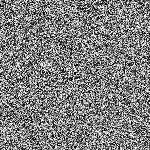

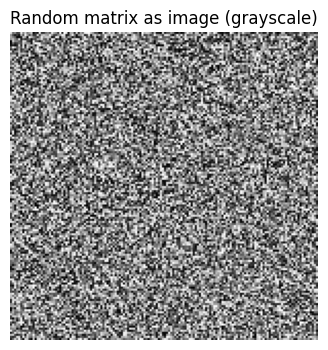

In [20]:
# --- Exercise 4: Image = Matrix (Colab-ready) ---

import numpy as np
import matplotlib.pyplot as plt

# OpenCV + Colab-safe display
import cv2
from google.colab.patches import cv2_imshow  # Colab uses this instead of cv2.imshow

# 1) Create a random grayscale "image" as a 2D matrix of uint8 in [0, 255]
H, W = 150, 150
random_matrix = np.random.randint(0, 256, size=(H, W), dtype=np.uint8)

# 2) Print the complete matrix and its metadata
print("Complete grayscale matrix:")
print(random_matrix)

print(f"\nMatrix shape: {random_matrix.shape}")  # (rows, cols) = (height, width)
print(f"Matrix data type: {random_matrix.dtype}")  # uint8 -> pixel range 0..255

# 3) Display with OpenCV (Colab)
cv2_imshow(random_matrix)  # works in Colab

# 4) Also display with Matplotlib (set grayscale + fixed range to match pixel values)
plt.figure(figsize=(5,4))
plt.imshow(random_matrix, cmap='gray', vmin=0, vmax=255)
plt.title("Random matrix as image (grayscale)")
plt.axis('off')
plt.show()


## 5. RGB Channels — Split & Merge 🌈


### 5.1. How RGB Channels work?

color_img shape: (5, 5, 3) (H, W, C)
dtype: uint8 min: 0 max: 255


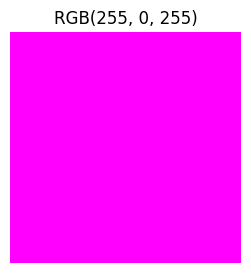

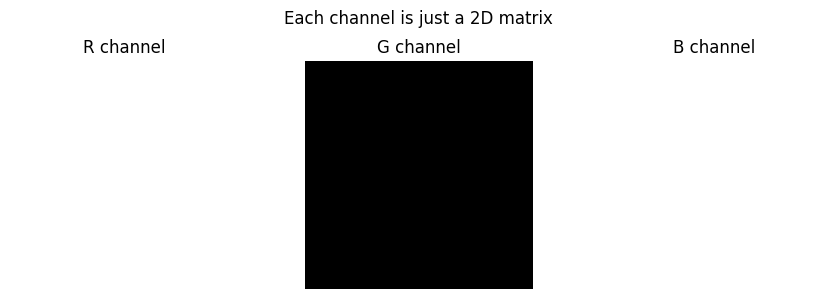

Merged equals original: True


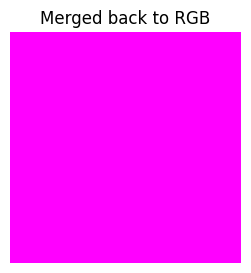

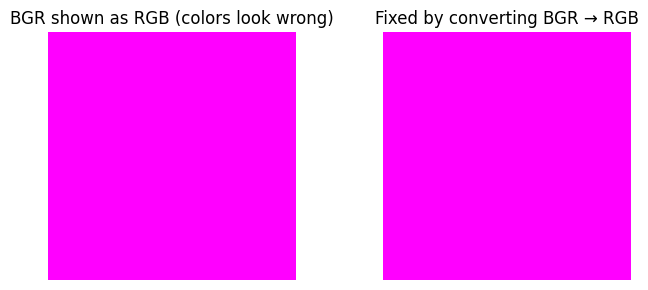

In [30]:
# --- COMP3057: RGB Channels — Split & Merge (Colab-ready) ---

import numpy as np
import matplotlib.pyplot as plt

# 1) Define image size and a color (EDIT THESE VALUES)
H, W = 5,5             # height, width
R, G, B = 255, 0, 255      # 0..255 per channel

# 2) Build a solid RGB image (H, W, 3)
color_img = np.zeros((H, W, 3), dtype=np.uint8)
color_img[..., 0] = R   # Red plane
color_img[..., 1] = G   # Green plane
color_img[..., 2] = B   # Blue plane

print("color_img shape:", color_img.shape, "(H, W, C)")
print("dtype:", color_img.dtype, "min:", color_img.min(), "max:", color_img.max())

# 3) Visualize the color (Matplotlib expects (H, W, 3) in RGB)
plt.figure(figsize=(4, 3))
plt.imshow(color_img)   # RGB image with uint8 0..255 values
plt.title(f"RGB({R}, {G}, {B})")
plt.axis("off")
plt.show()

# 4) Split channels (each is a 2D matrix)
R_ch = color_img[..., 0]
G_ch = color_img[..., 1]
B_ch = color_img[..., 2]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(R_ch, cmap="gray", vmin=0, vmax=255); axes[0].set_title("R channel"); axes[0].axis("off")
axes[1].imshow(G_ch, cmap="gray", vmin=0, vmax=255); axes[1].set_title("G channel"); axes[1].axis("off")
axes[2].imshow(B_ch, cmap="gray", vmin=0, vmax=255); axes[2].set_title("B channel"); axes[2].axis("off")
plt.suptitle("Each channel is just a 2D matrix")
plt.tight_layout(); plt.show()

# 5) Merge channels back to RGB
merged = np.stack([R_ch, G_ch, B_ch], axis=-1)
print("Merged equals original:", np.array_equal(merged, color_img))

plt.figure(figsize=(4, 3))
plt.imshow(merged)
plt.title("Merged back to RGB")
plt.axis("off")
plt.show()

# 6) Bonus: demonstrate the BGR↔RGB mix-up (common with OpenCV)
bgr = np.stack([B_ch, G_ch, R_ch], axis=-1)  # (B, G, R)
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(bgr); ax[0].set_title("BGR shown as RGB (colors look wrong)"); ax[0].axis("off")
ax[1].imshow(bgr[..., ::-1]); ax[1].set_title("Fixed by converting BGR → RGB"); ax[1].axis("off")
plt.tight_layout(); plt.show()


**Visualize the pixels you create**

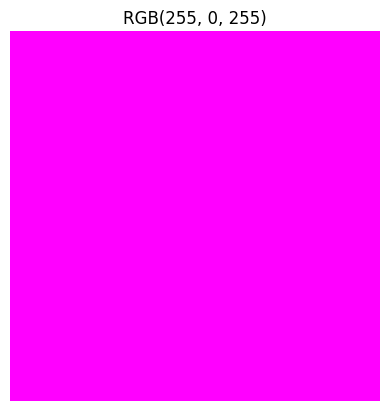

Current color: RGB(255, 0, 255)

🎯 Try changing the R, G, B values above!
• Pure Red: (255, 0, 0)
• Pure Green: (0, 255, 0)
• Pure Blue: (0, 0, 255)
• Yellow: (255, 255, 0)
• White: (255, 255, 255)


In [31]:
# Display the color
plt.imshow(color_img)
plt.title(f'RGB({R}, {G}, {B})')
plt.axis('off')
plt.show()

print(f"Current color: RGB({R}, {G}, {B})")
print("\n🎯 Try changing the R, G, B values above!")
print("• Pure Red: (255, 0, 0)")
print("• Pure Green: (0, 255, 0)")
print("• Pure Blue: (0, 0, 255)")
print("• Yellow: (255, 255, 0)")
print("• White: (255, 255, 255)")

### 5.2. Visualize each channel as a grayscale image, then recompose.

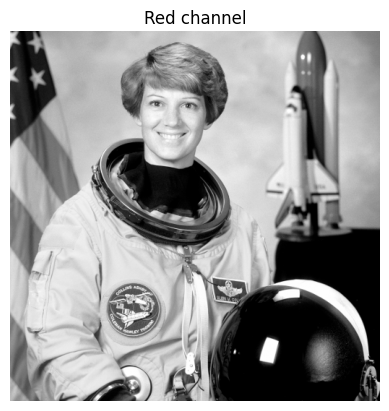

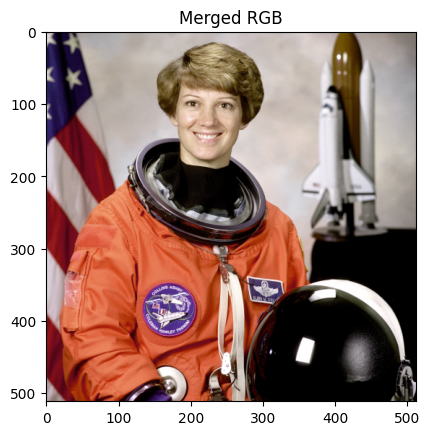

In [21]:
R, G, B = img_rgb[0], img_rgb[1], img_rgb[2]

# Show R channel
plt.imshow(R, cmap='gray')
plt.title('Red channel')
plt.axis('off')
plt.show()

# Merge back
merged = torch.stack([R, G, B])
plt.imshow(merged.permute(1, 2, 0))
plt.title('Merged RGB')
plt.show()

## 6. Simple Image Ops (Crop, Brightness, Concat) ✂️🔆➕

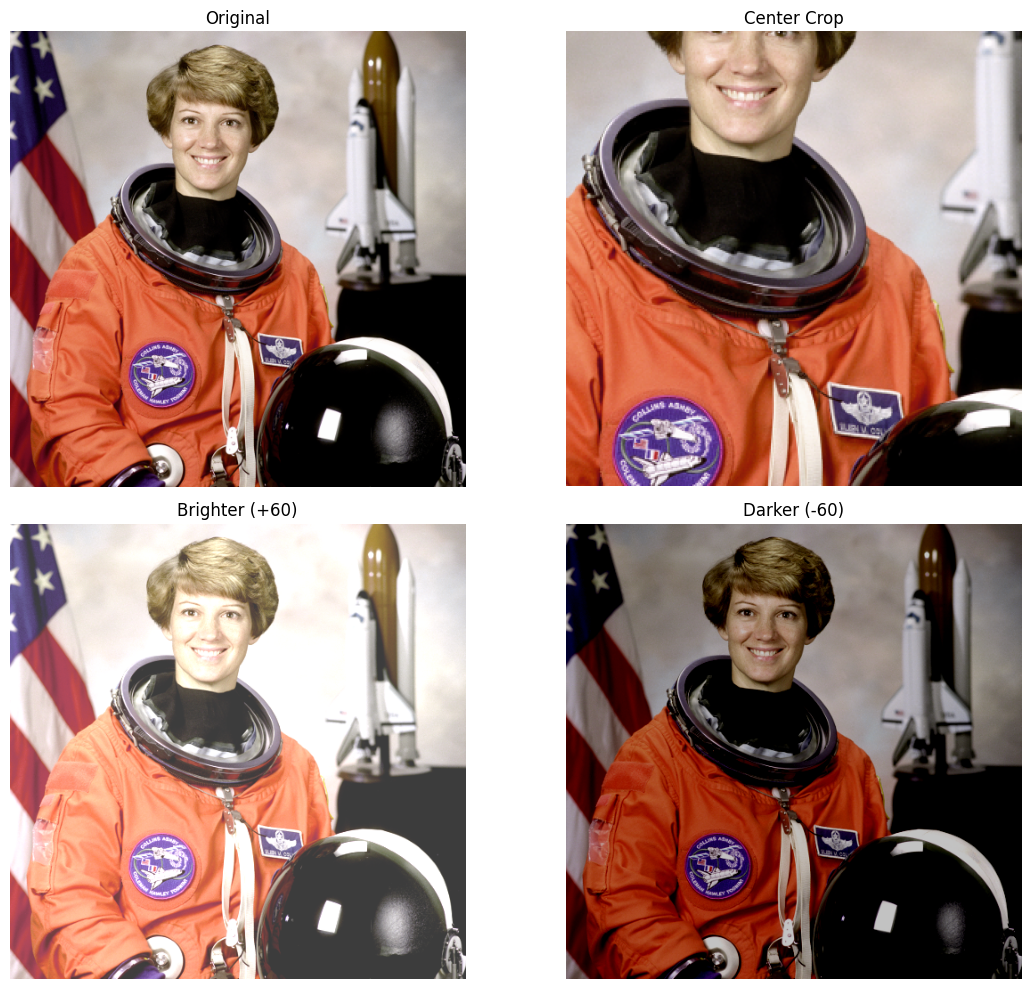

In [32]:
# --- COMP3057: Simple Image Ops (Crop, Brightness, Concat) — Colab-ready ---

import numpy as np
import torch
import matplotlib.pyplot as plt

# Try a built-in sample image (no downloads). Fall back to a synthetic gradient if skimage isn't available.
try:
    from skimage import data as skidata  # built-in samples like astronaut(), camera(), coffee()
    np_img = skidata.astronaut()  # HxWx3, uint8
except Exception:
    H, W = 256, 256
    y = np.linspace(0, 255, H, dtype=np.uint8)[:, None]
    x = np.linspace(0, 255, W, dtype=np.uint8)[None, :]
    np_img = np.dstack([x, y, ((x + y) // 2).astype(np.uint8)])  # synthetic RGB gradient

# 1) Make a CHW torch tensor called img_rgb (C,H,W), uint8 in [0,255]
img_rgb = torch.from_numpy(np_img).permute(2, 0, 1).contiguous()  # (3,H,W), uint8

# 2) Center crop (channels-first)
def center_crop_chw(img: torch.Tensor, crop_h: int, crop_w: int) -> torch.Tensor:
    C, H, W = img.shape
    th = min(crop_h, H)
    tw = min(crop_w, W)
    top  = max((H - th) // 2, 0)
    left = max((W - tw) // 2, 0)
    return img[:, top:top + th, left:left + tw]

# pick a crop that's 60% of the shortest side
C, H, W = img_rgb.shape
side = int(0.6 * min(H, W))
cropped = center_crop_chw(img_rgb, side, side)

# 3) Brightness (avoid uint8 wrap-around by upcasting, then clamp)
def adjust_brightness_u8(img: torch.Tensor, delta: int) -> torch.Tensor:
    tmp = img.to(torch.int16) + int(delta)  # upcast to avoid overflow
    return torch.clamp(tmp, 0, 255).to(torch.uint8)

bright = adjust_brightness_u8(img_rgb, +60)
dark   = adjust_brightness_u8(img_rgb, -60)

# 4) (Optional) Concats for later demos
concat_h = torch.cat([img_rgb, img_rgb], dim=2)  # wider
concat_v = torch.cat([img_rgb, img_rgb], dim=1)  # taller

# 5) Display results (your original plotting snippet)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].imshow(img_rgb.permute(1,2,0))          # HWC for matplotlib
axes[0,0].set_title('Original');     axes[0,0].axis('off')

axes[0,1].imshow(cropped.permute(1,2,0))
axes[0,1].set_title('Center Crop');  axes[0,1].axis('off')

axes[1,0].imshow(bright.permute(1,2,0))
axes[1,0].set_title('Brighter (+60)'); axes[1,0].axis('off')

axes[1,1].imshow(dark.permute(1,2,0))
axes[1,1].set_title('Darker (-60)');  axes[1,1].axis('off')

plt.tight_layout()
plt.show()


**Display results**

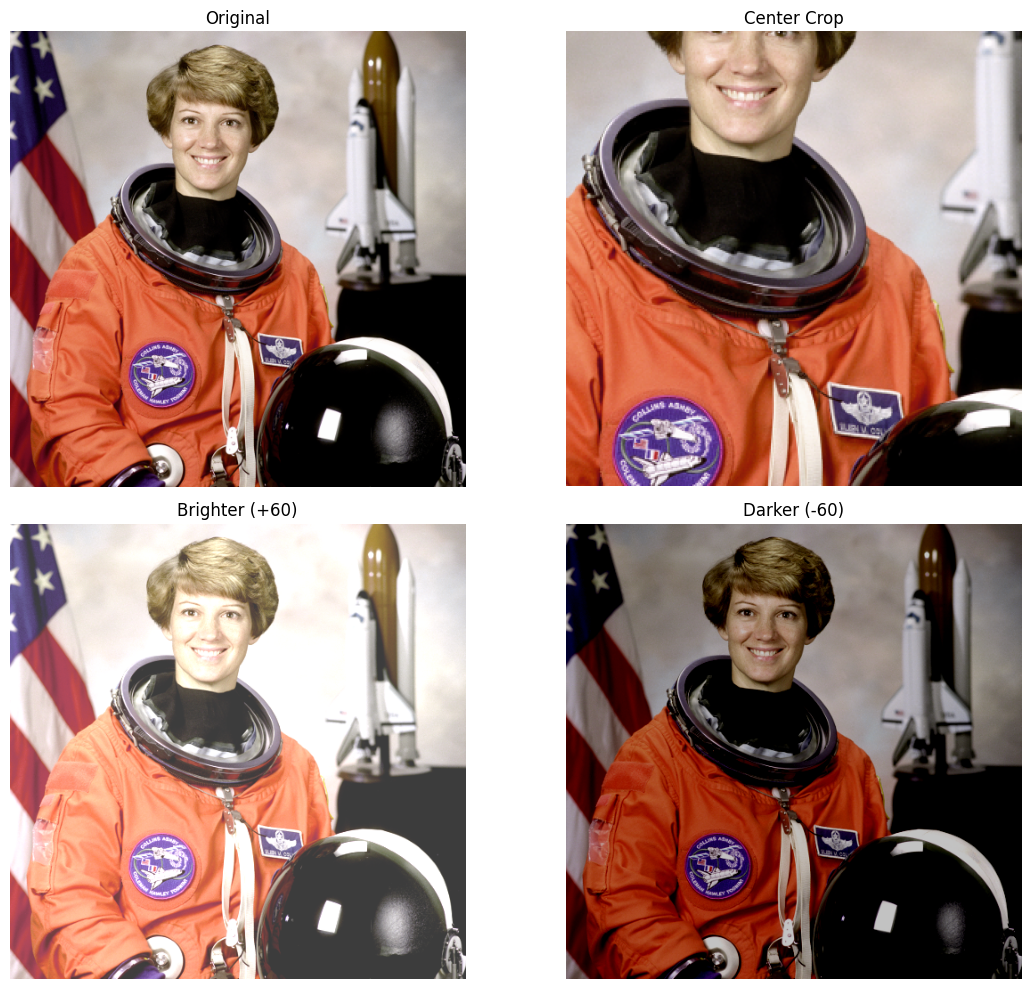

In [33]:
# Display results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0,0].imshow(img_rgb.permute(1,2,0))
axes[0,0].set_title('Original')
axes[0,0].axis('off')

axes[0,1].imshow(cropped.permute(1,2,0))
axes[0,1].set_title('Center Crop')
axes[0,1].axis('off')

axes[1,0].imshow(bright.permute(1,2,0))
axes[1,0].set_title('Brighter (+60)')
axes[1,0].axis('off')

axes[1,1].imshow(dark.permute(1,2,0))
axes[1,1].set_title('Darker (-60)')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

## 7: Image crop using Python Indexing

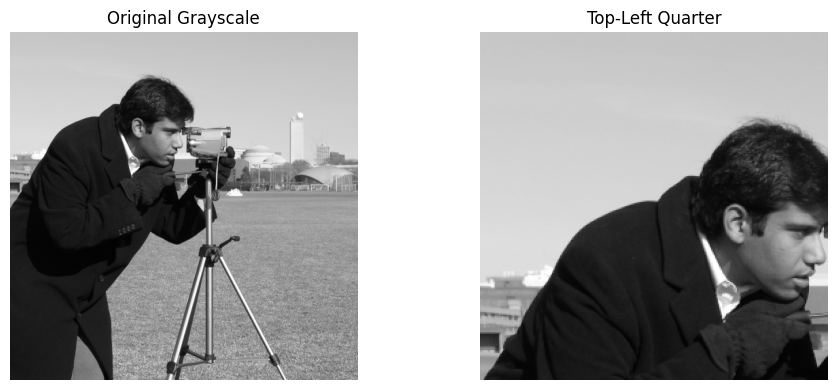

img_gray shape: (1, 512, 512) (C, H, W)
top_left shape: (1, 256, 256)


In [35]:
# --- COMP3057: Image crop via Python indexing (Colab-ready) ---

import numpy as np
import torch
import matplotlib.pyplot as plt

# 1) Get a sample *grayscale* image (no downloads)
try:
    from skimage import data as skdata            # built-in images
    img2d = skdata.camera().astype(np.uint8)      # (H, W), uint8 0..255
except Exception:
    # Fallback: synthetic 2D gradient
    H, W = 256, 256
    y = np.linspace(0, 255, H, dtype=np.uint8)[:, None]
    x = np.linspace(0, 255, W, dtype=np.uint8)[None, :]
    img2d = ((x + y) // 2).astype(np.uint8)

# 2) Convert to a CHW-style grayscale tensor: (1, H, W)
img_gray = torch.from_numpy(img2d).unsqueeze(0).contiguous()  # add channel dim

# 3) Define top-left quarter crop via indexing
_, H, W = img_gray.shape
top_left = img_gray[:, :H//2, :W//2]   # rows 0..H/2, cols 0..W/2

# 4) Plot original vs crop
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_gray.squeeze(0), cmap='gray', vmin=0, vmax=255)  # squeeze C=1 for display
plt.title('Original Grayscale')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(top_left.squeeze(0), cmap='gray', vmin=0, vmax=255)
plt.title('Top-Left Quarter')
plt.axis('off')

plt.tight_layout()
plt.show()

print("img_gray shape:", tuple(img_gray.shape), "(C, H, W)")
print("top_left shape:", tuple(top_left.shape))


**Results Display**

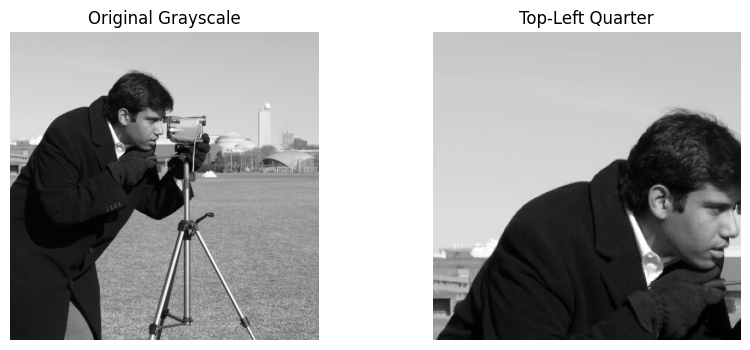

In [39]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_gray.squeeze(0), cmap='gray')
plt.title('Original Grayscale')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(top_left.squeeze(0), cmap='gray')
plt.title('Top-Left Quarter')
plt.axis('off')
plt.show()

## 8. Image Resolution Demonstration 📐

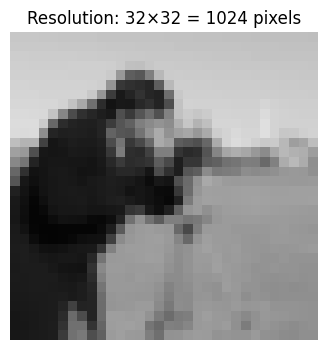

Current resolution: 32×32 pixels
Total pixels: 1024


In [46]:
# --- Image Resolution Demo using the *real* sample image (skimage.data.camera) ---

import numpy as np
import matplotlib.pyplot as plt

# 1) Load a real built-in grayscale image (no downloads)
from skimage import data as skdata
from skimage.transform import resize

img2d = skdata.camera().astype(np.uint8)  # shape: (H0, W0), uint8 in [0,255]

# 2) (Optional) Choose a new resolution; set to None to keep original
new_height, new_width = 32, 32  # e.g., try 64x64, 96x144, 128x192
# new_height, new_width = None, None

if new_height is not None and new_width is not None:
    resized_img = resize(
        img2d,
        (new_height, new_width),
        preserve_range=True,      # keep 0..255 scale
        anti_aliasing=True        # smoother when downsampling
    ).astype(np.uint8)
else:
    resized_img = img2d

# 3) Get the true resolution from the array shape (rows=height, cols=width)
height, width = resized_img.shape

# 4) Show it (fix grayscale range so 0..255 maps correctly)
plt.figure(figsize=(5, 4))
plt.imshow(resized_img, cmap='gray', vmin=0, vmax=255)
plt.title(f'Resolution: {height}×{width} = {height*width} pixels')
plt.axis('off')
plt.show()

print(f"Current resolution: {height}×{width} pixels")
print(f"Total pixels: {height*width}")


**Display the resized image**

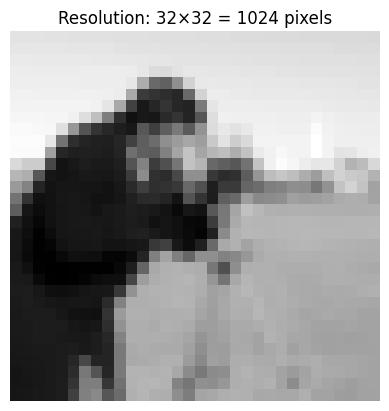

Current resolution: 32×32 pixels
Total pixels: 1024

Matrix (downsized copy for readability):
[[199 199 199 198 198 197 197 197 197 196 196 196 195 195 195 195 194 194 194 193 193 193 192 192 192 191 191 191 191 191 191 190]
 [201 201 201 201 201 200 200 200 200 199 198 198 198 197 197 197 197 196 196 196 195 195 195 195 194 194 194 194 193 193 193 193]
 [205 205 204 204 204 204 204 203 203 202 202 201 200 200 199 199 199 199 199 198 198 197 197 197 197 196 196 196 196 196 195 195]
 [207 207 206 206 206 206 207 207 207 207 206 202 192 191 198 202 202 201 201 201 200 200 200 199 199 199 199 198 198 198 198 197]
 [208 208 208 208 208 208 207 207 207 207 202 152  94  87 127 184 203 204 203 203 203 202 202 202 202 201 201 201 200 200 199 199]
 [211 211 210 210 210 210 210 210 209 206 149  55  48  44  38  94 185 206 206 205 205 204 204 204 204 204 203 203 202 202 201 201]
 [213 213 213 212 212 212 212 211 200 149  60  25  37  50  38  34 110 200 207 207 207 207 206 206 206 206 206 205 204 20

In [50]:
# Display the resized image
plt.imshow(resized_img, cmap='gray')
plt.title(f'Resolution: {height}×{width} = {height*width} pixels')
plt.axis('off')
plt.show()

print(f"Current resolution: {height}×{width} pixels")
print(f"Total pixels: {height*width}")
np.set_printoptions(threshold=resized_img.size, linewidth=200)  # show all values
print("\nMatrix (downsized copy for readability):")
print(resized_img)

Original image shape: 512×512, dtype=uint8

Matrix (downsized copy for readability):
[[199 199 199 199 198 198 198 198 197 197 197 196 196 196 195 195 195 194 194 194 194 193 193 193 192 192 192 192 191 191 191 191]
 [203 203 203 202 202 202 202 202 201 201 200 199 199 199 198 198 198 198 197 197 197 196 196 196 196 195 195 195 195 194 194 194]
 [207 206 206 206 206 206 207 206 206 206 205 200 189 188 196 201 201 201 200 200 200 199 199 199 199 198 198 198 198 197 197 197]
 [209 209 209 208 208 208 208 208 208 207 192 132  87  81 108 167 201 204 204 203 203 203 202 202 202 202 201 201 201 200 200 199]
 [212 212 211 211 211 211 211 210 205 183 104  39  44  48  37  61 149 204 207 206 206 206 205 205 205 205 204 204 203 203 202 202]
 [215 215 214 214 213 207 192 172 129  64  26  27  28  45  50  37  85 195 209 208 208 208 208 208 208 208 211 208 206 206 206 205]
 [218 218 218 214 178 115  72  51  39  32  31  79  66  93 109  92 127 187 202 194 200 211 211 211 210 211 220 211 209 208 208 207

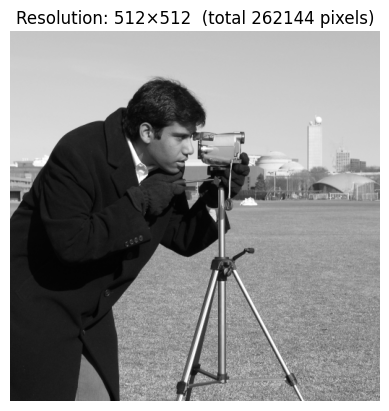

In [48]:
# --- Print the image matrix (simple) ---

import numpy as np
import matplotlib.pyplot as plt
from skimage import data as skdata
from skimage.transform import resize

# 1) Load a real grayscale image (0..255)
img = skdata.camera().astype(np.uint8)   # shape (H, W)
H, W = img.shape
print(f"Original image shape: {H}×{W}, dtype={img.dtype}")

# 2) (Optional) Make a small version just for printing numbers nicely
small_h, small_w = 24, 32  # change if you want more/less numbers
img_small = resize(img, (small_h, small_w), preserve_range=True, anti_aliasing=True).astype(np.uint8)

# 3) Print the matrix (no truncation)
np.set_printoptions(threshold=img_small.size, linewidth=200)  # show all values
print("\nMatrix (downsized copy for readability):")
print(img_small)

# 4) Display the original image correctly in grayscale
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Resolution: {H}×{W}  (total {H*W} pixels)")
plt.axis('off')
plt.show()
